In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_acc = pd.read_csv('Linear Accelerometer.csv')
df_gps = pd.read_csv('Location.csv')

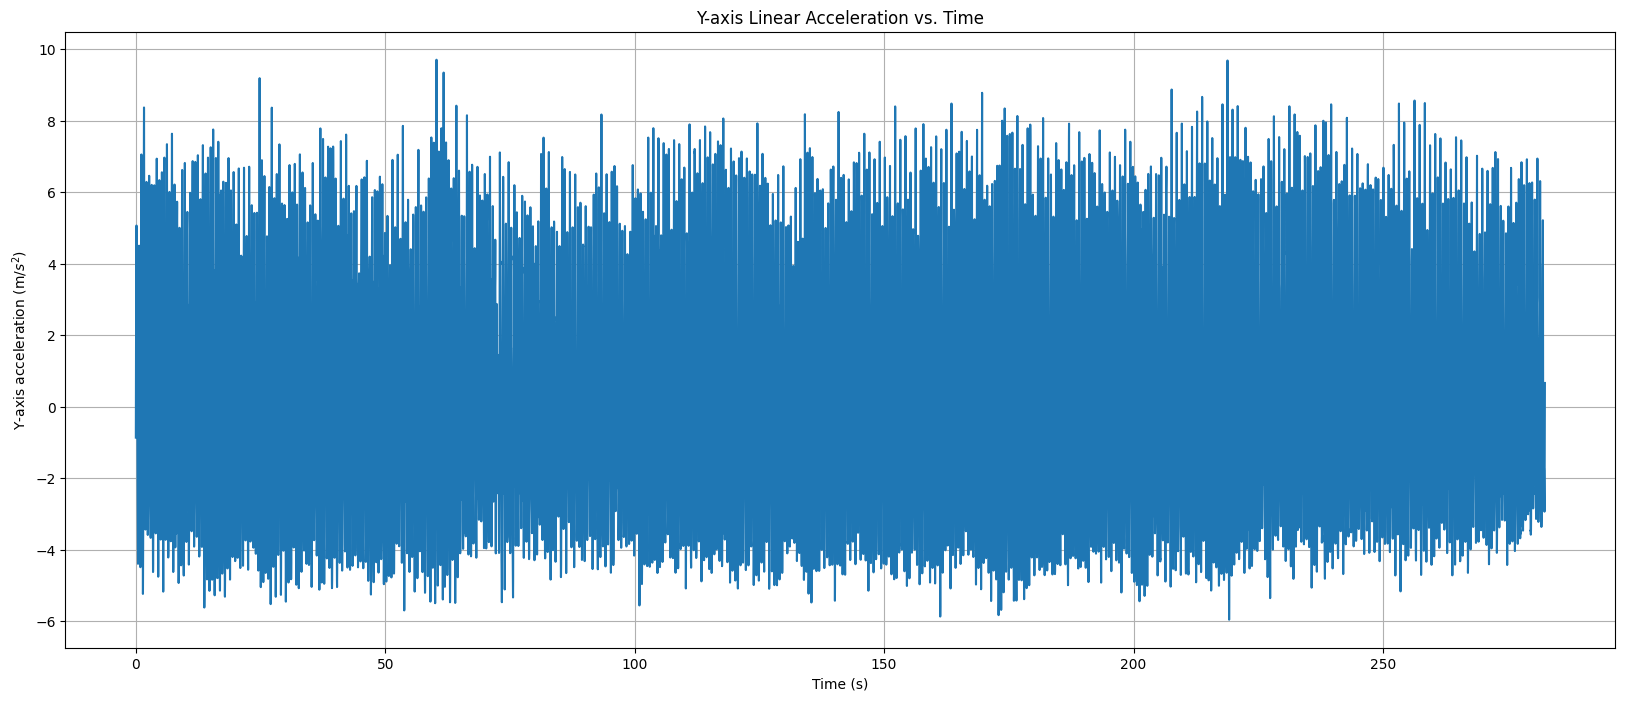

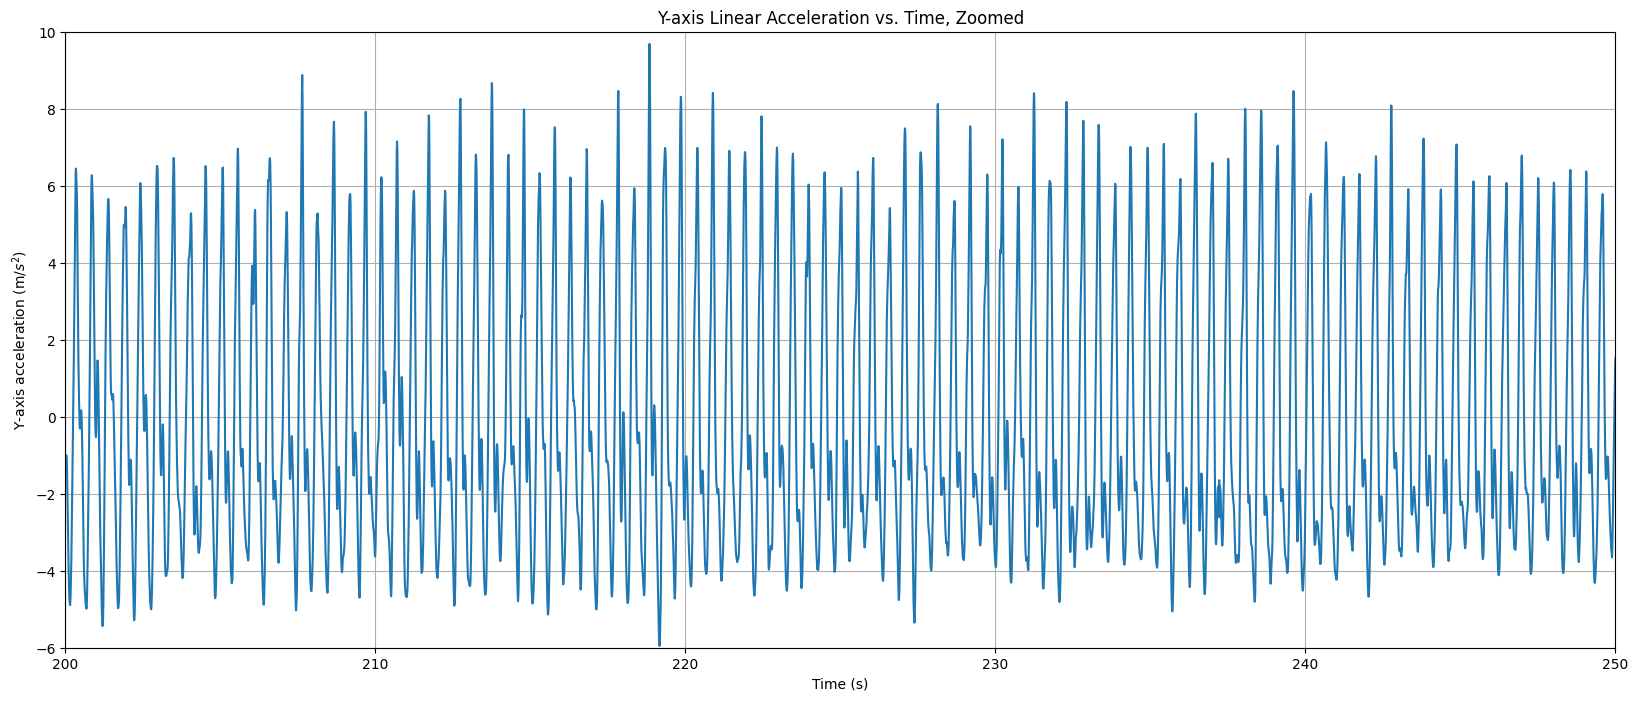

In [251]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_acc['Time (s)'], df_acc['Y (m/s^2)'])
plt.xlabel('Time (s)')
plt.ylabel('Y-axis acceleration (m$/s^2$)')
plt.grid()
plt.title('Y-axis Linear Acceleration vs. Time')
plt.show()

fig = plt.figure(figsize=(20,8))
plt.plot(df_acc['Time (s)'], df_acc['Y (m/s^2)'])
plt.xlabel('Time (s)')
plt.ylabel('Y-axis acceleration (m$/s^2$)')
plt.grid()
plt.title('Y-axis Linear Acceleration vs. Time, Zoomed')
plt.axis([200, 250, -6, 10]) # zoomataan vähän että erottaa jotain
plt.show()

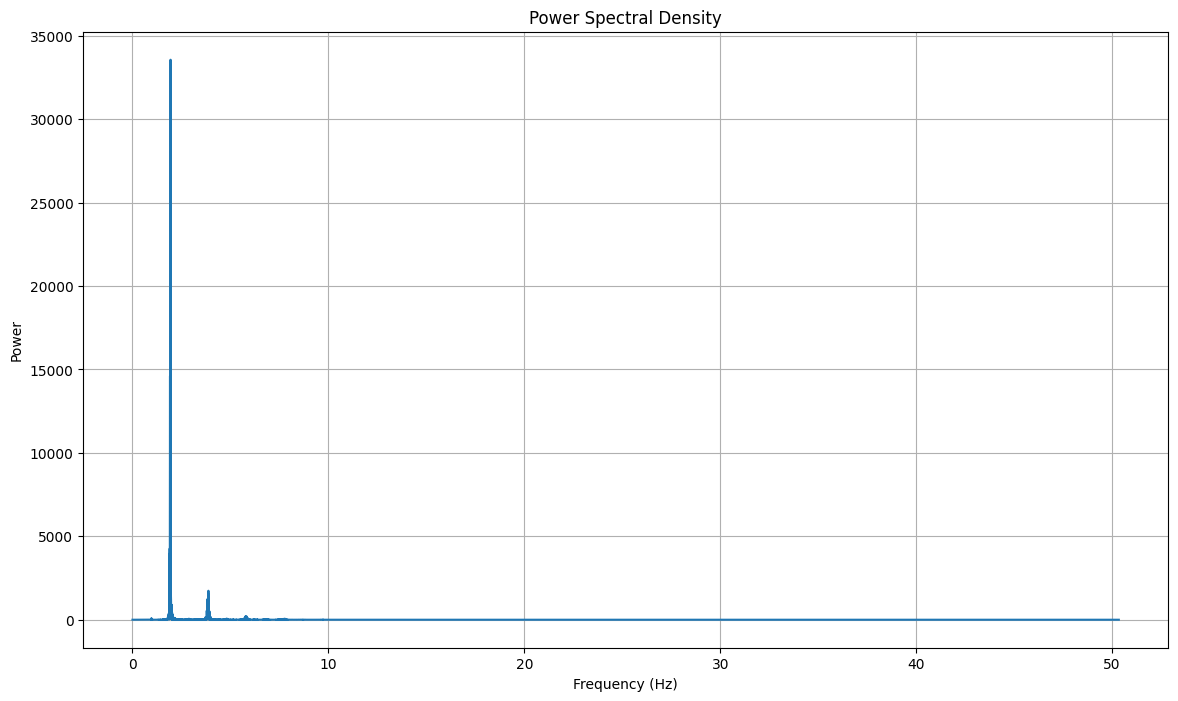

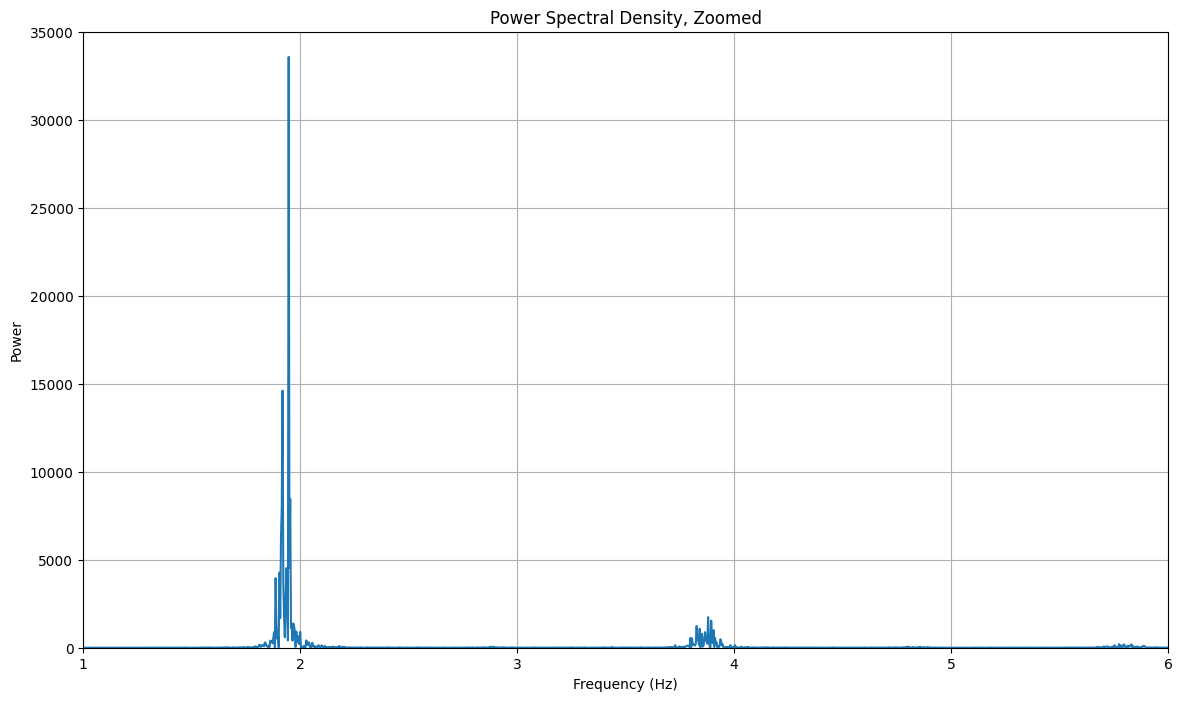

In [252]:
# askelmäärän laskeminen fourier-muunnoksen avulla

# lasketaan fourier-muunnos ja tehospektri

f = df_acc['Y (m/s^2)'] # signaali
t = df_acc['Time (s)'] # aika
N = len(f) # havaintojen määrä
dt = np.max(t) / N # näytteistysväli

fourier = np.fft.fft(f, N) # fourier-muunnos
psd = fourier * np.conj(fourier) / N # tehospektri
freq = np.fft.fftfreq(N, dt) # kaikki mahdolliset taajuudet
L = np.arange(1, np.floor(N/2), dtype='int') # negatiivisten ja nollataajuuksien poisto

plt.figure(figsize=(14,8))
plt.plot(freq[L], psd[L].real)
plt.xlabel('Frequency (Hz)') # Hz = 1/s
plt.ylabel('Power')
plt.grid()
plt.title('Power Spectral Density')
plt.show()

plt.figure(figsize=(14,8))
plt.plot(freq[L], psd[L].real)
plt.axis([1, 6, 0, 35000]) # zoomataan
plt.xlabel('Frequency (Hz)') # Hz = 1/s
plt.ylabel('Power')
plt.grid()
plt.title('Power Spectral Density, Zoomed')
plt.show()



# selkein piikki on yhden askeleen taajuus
# seuraava n. 3.5Hz minipiikki on kahden askeleen taajuus, johtuu yleisestä ihmisen vaappumisesta yms

In [253]:
# mitataan askelia

# etsitään suurin tehospektrin arvo eli maksimitaajuus, näitä tapoja on monta mutta tehdään nyt näin
f_max = freq[L][psd[L] == np.max(psd[L])][0] # taajuuden arvo, kun tehon arvo on suurin, viimeinen [0] on tarpeen, koska muuten saadaan array
print("Maksimitaajuus:", f_max)

T = 1/f_max # askeleen jaksonaika
print("Askeleen pituus sekunneissa, Fourier-muunnoksella laskettuna:", T)

steps_fourier = np.max(t) * f_max # askeleiden määrä
print("Askelten määrä, Fourier-muunnoksella laskettuna:", steps_fourier)

Maksimitaajuus: 1.9471084039168833
Askeleen pituus sekunneissa, Fourier-muunnoksella laskettuna: 0.5135820881818182
Askelten määrä, Fourier-muunnoksella laskettuna: 550.0


In [254]:
# lasketaan askeleet suodatetusta kiihtyvyysdatasta

# tuodaan filtterifunktiot

from scipy.signal import butter, filtfilt

def butter_lowpass(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    # get filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    # get filter coefficients
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y


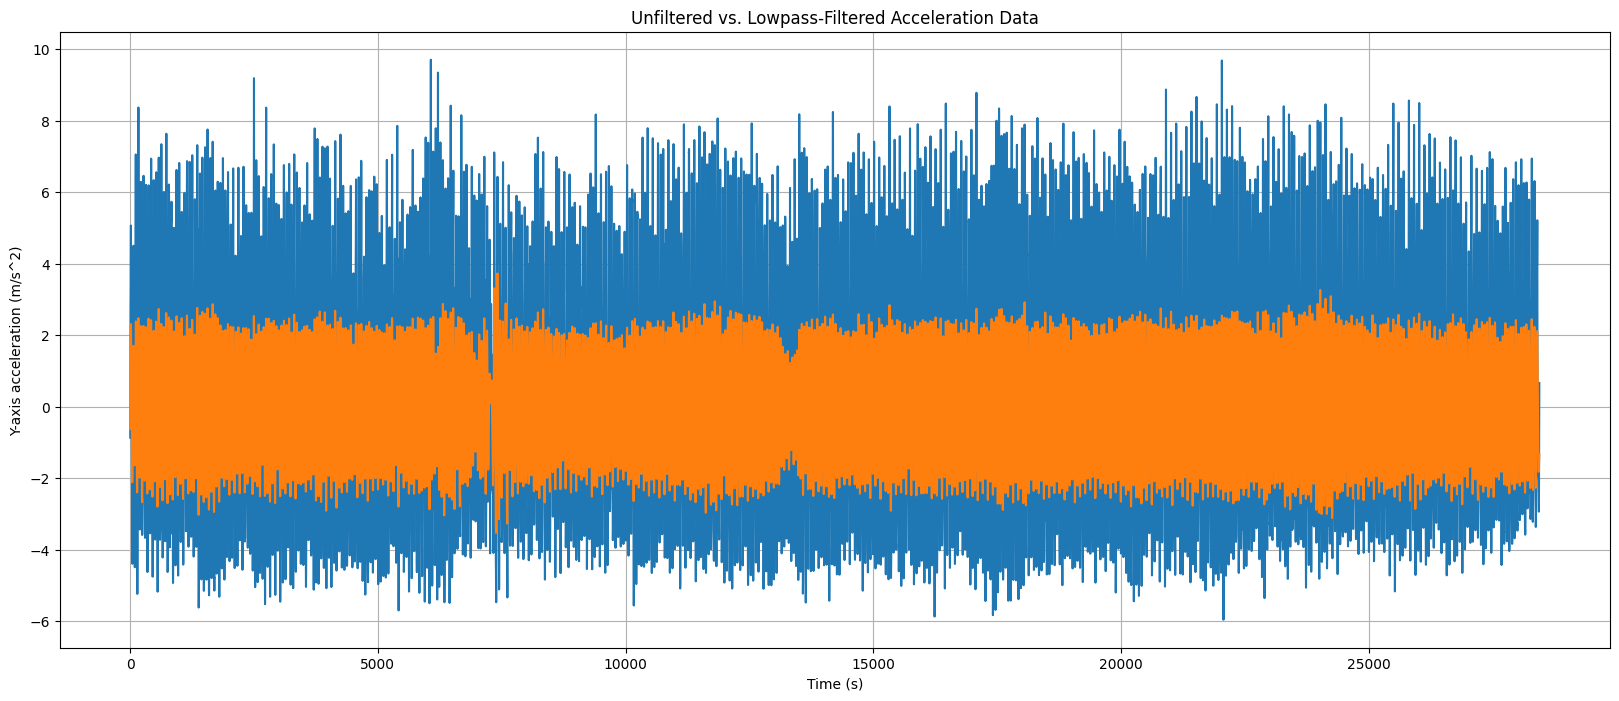

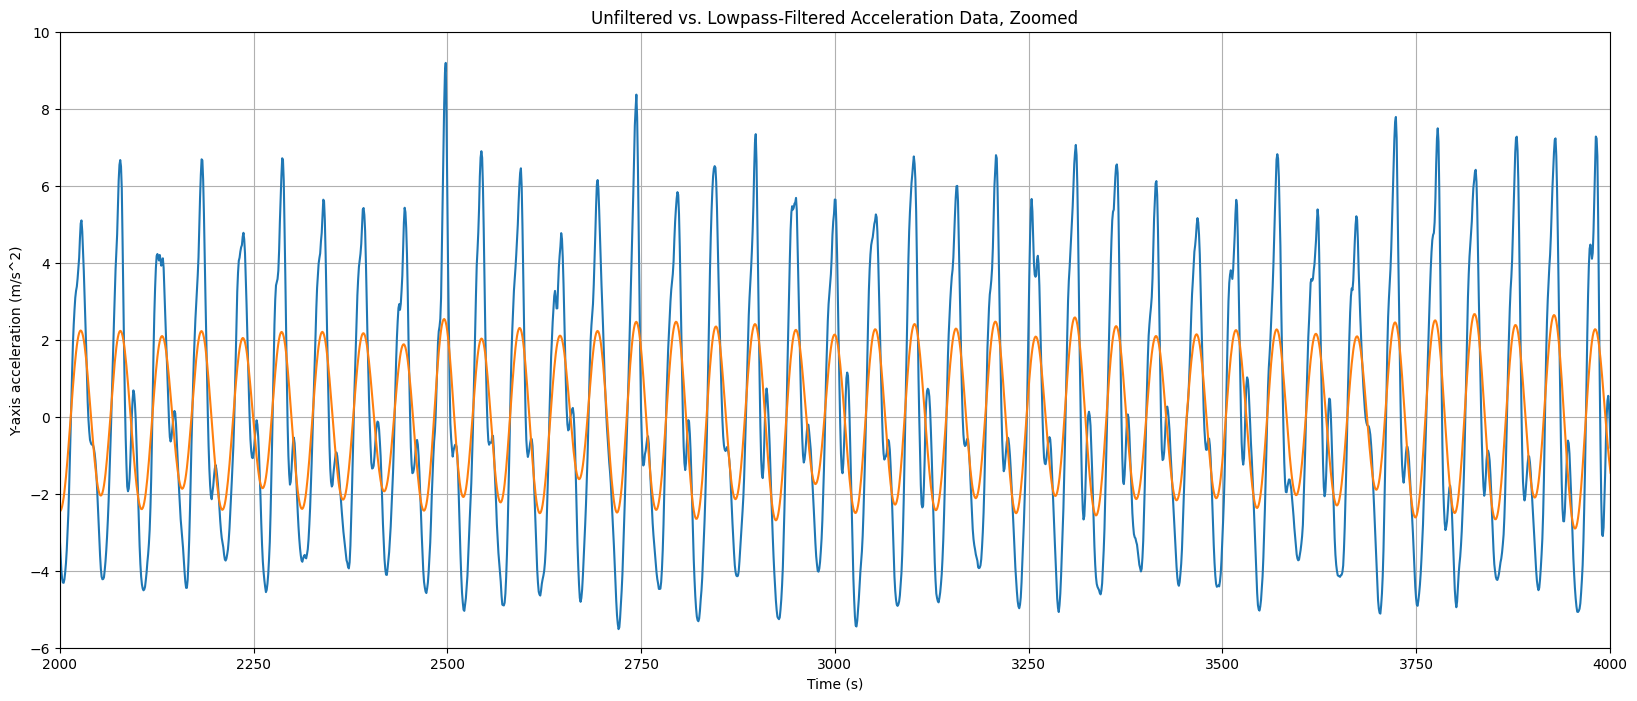

In [255]:
# käytetään alipäästösuodatinta (lowpass) jotta saadaan poistettua korkeataajuiset kiihtyvyyden muutokset

aika = df_acc['Time (s)']
kiihtyvyys = df_acc['Y (m/s^2)']

data = kiihtyvyys
T = aika.max() - aika.min() # n. 63.64 s
n = len(aika)
fs = n/T 
nyq = fs/2 
order = 3
cutoff = 1/0.5 # vedetty vähän hatusta, kannattaa kokeilla eri arvoja

filtered_signal = butter_lowpass(data, cutoff, fs, nyq, order)

plt.figure(figsize=(20,8))
plt.plot(kiihtyvyys)
plt.plot(filtered_signal)
plt.grid()
plt.title('Unfiltered vs. Lowpass-Filtered Acceleration Data')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis acceleration (m/s^2)')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(kiihtyvyys)
plt.plot(filtered_signal)
plt.grid()
plt.axis([2000, 4000, -6, 10])
plt.title('Unfiltered vs. Lowpass-Filtered Acceleration Data, Zoomed')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis acceleration (m/s^2)')
plt.show()

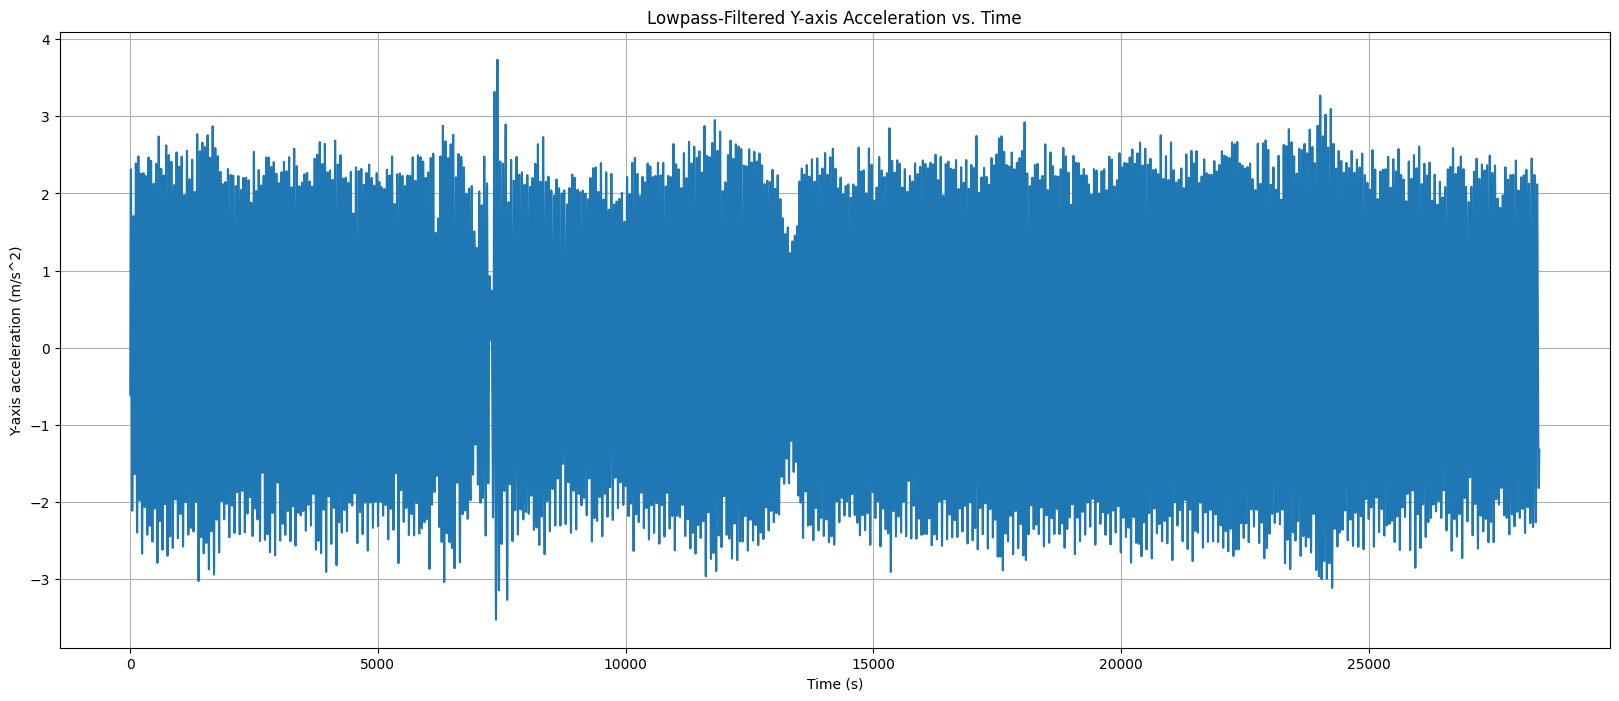

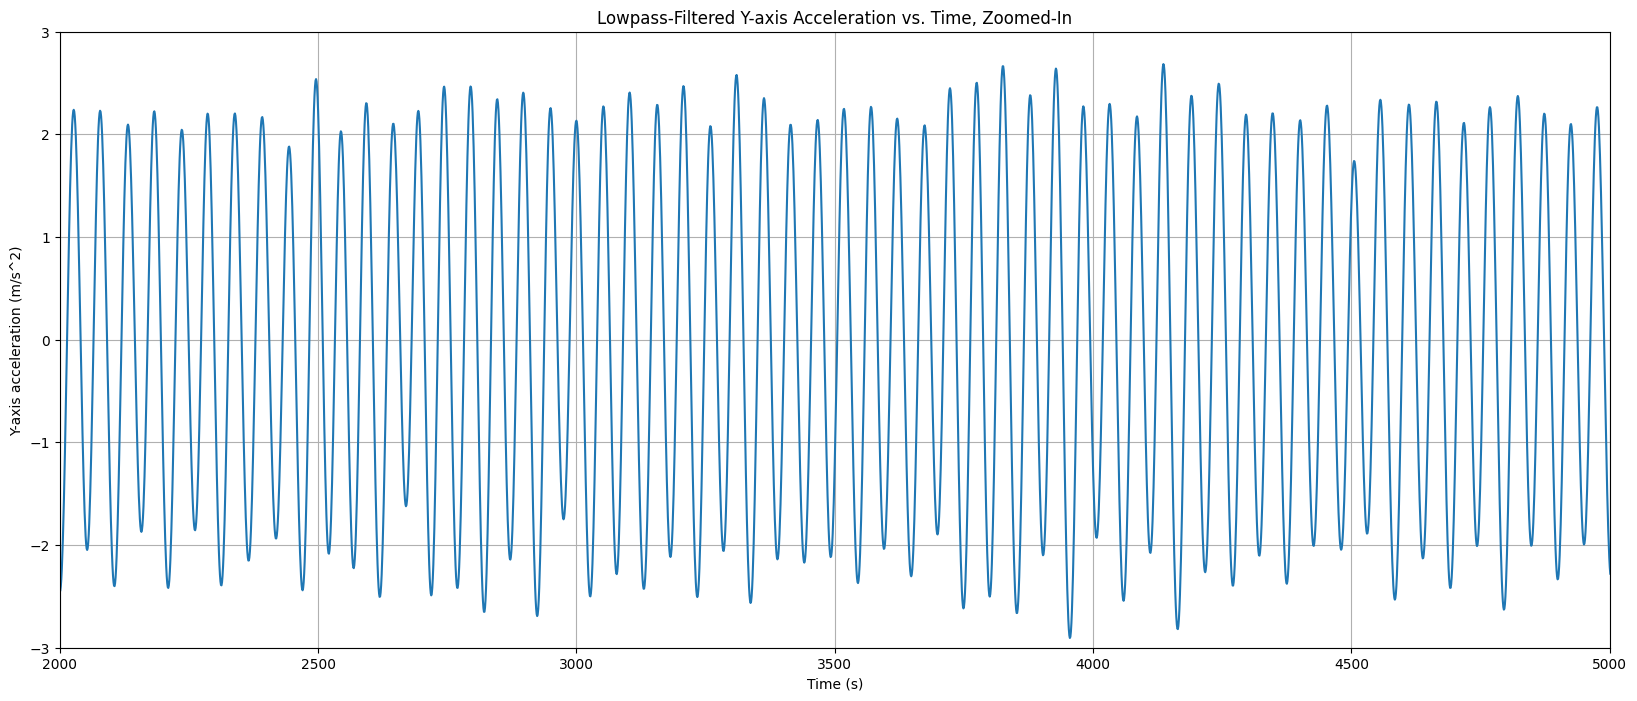

In [256]:
plt.figure(figsize=(20,8))
plt.plot(filtered_signal)
plt.ylabel('Y-axis acceleration (m/s^2)')
plt.xlabel('Time (s)')
plt.title('Lowpass-Filtered Y-axis Acceleration vs. Time')
plt.grid()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(filtered_signal)
plt.ylabel('Y-axis acceleration (m/s^2)')
plt.xlabel('Time (s)')
plt.title('Lowpass-Filtered Y-axis Acceleration vs. Time, Zoomed-In')
plt.grid()
plt.axis([2000, 5000, -3, 3]) # zoomataan
plt.show()

In [257]:
# nollakohtien ylitys

ylitykset = 0
for i in range(n-1): # miinus yksi koska viimeistä ei voi verrata seuraavaan
    if filtered_signal[i] / filtered_signal[i+1] < 0: # true jos molemmat ovat eri merkkisiä eli nollan ylitys
        ylitykset = ylitykset + 1

steps_lowpass = ylitykset / 2

print("Askelten määrä, Butterworth-filtterillä alipäästösuodatettu:", steps_lowpass)

Askelten määrä, Butterworth-filtterillä alipäästösuodatettu: 545.0


In [258]:
# gps-datasta keskinopeus ja kuljettu matka

from math import radians, cos, sin, asin, sqrt
import folium

# haversinen kaava pisteiden välimatkojen laskemiseen

def haversine(lon1, lat1, lon2, lat2):
    # muutetaan asteet radiaaneiksi
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversinen kaava
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # maapallon säde km
    return c * r



In [259]:
# lasketaan nopeus ja matka (vaikka ne olisivat jo valmiina tiedostossa)

df_gps['dist'] = np.zeros(len(df_gps)) # tyhjä sarakkeen matkoille
df_gps['time_diff'] = np.zeros(len(df_gps)) # tyhjä sarakkeen ajoille

for i in range(len(df_gps)-1):
    # lasketaan kahden peräkkäisen pisteen välimatka ja kerrotaan se 1000:lla saadaksemme metrit
    df_gps.loc[i, 'dist'] = haversine(df_gps['Longitude (°)'][i], df_gps['Latitude (°)'][i], df_gps['Longitude (°)'][i+1], df_gps['Latitude (°)'][i+1])*1000
    # lasketaan peräkkäisten pisteiden välinen aika
    df_gps.loc[i,'time_diff'] = df_gps['Time (s)'][i+1] - df_gps['Time (s)'][i]
    # lasketaan oma nopeus
    df_gps['velocity'] = df_gps['dist'] / df_gps['time_diff']
    # koko matka
    df_gps['tot_dist'] = np.cumsum(df_gps['dist'])

total_distance = df_gps['tot_dist'].iloc[-1] # viimeinen rivi
print("Kokonaismatka:", total_distance, "metriä")

velocity_avg = total_distance / df_gps['Time (s)'].iloc[-1]
print("Keskinopeus:", velocity_avg, "m/s")

# nähdään, että on lisätty dataframeen
df_gps.head()

Kokonaismatka: 459.91816407906 metriä
Keskinopeus: 1.6319138230440062 m/s


,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (°),dist,time_diff,velocity,tot_dist
0,0.008699,65.046742,25.433111,7.539292,NaN,NaN,17.516182,30.000000,0.052867,0.049880,1.059875,0.052867
1,0.058579,65.046741,25.433111,7.539292,NaN,NaN,28.745039,30.000628,5.199196,1.727252,3.010097,5.252063
2,1.785831,65.046723,25.433213,7.833776,NaN,NaN,19.087056,30.000000,10.125378,0.895853,11.302499,15.377441
3,2.681684,65.046805,25.433120,9.829590,0.51,301.289062,11.432633,24.000000,3.643643,1.002948,3.632933,19.021085
4,3.684632,65.046818,25.433049,-0.939697,1.05,NaN,11.483733,24.000000,16.159585,1.158937,13.943455,35.180670


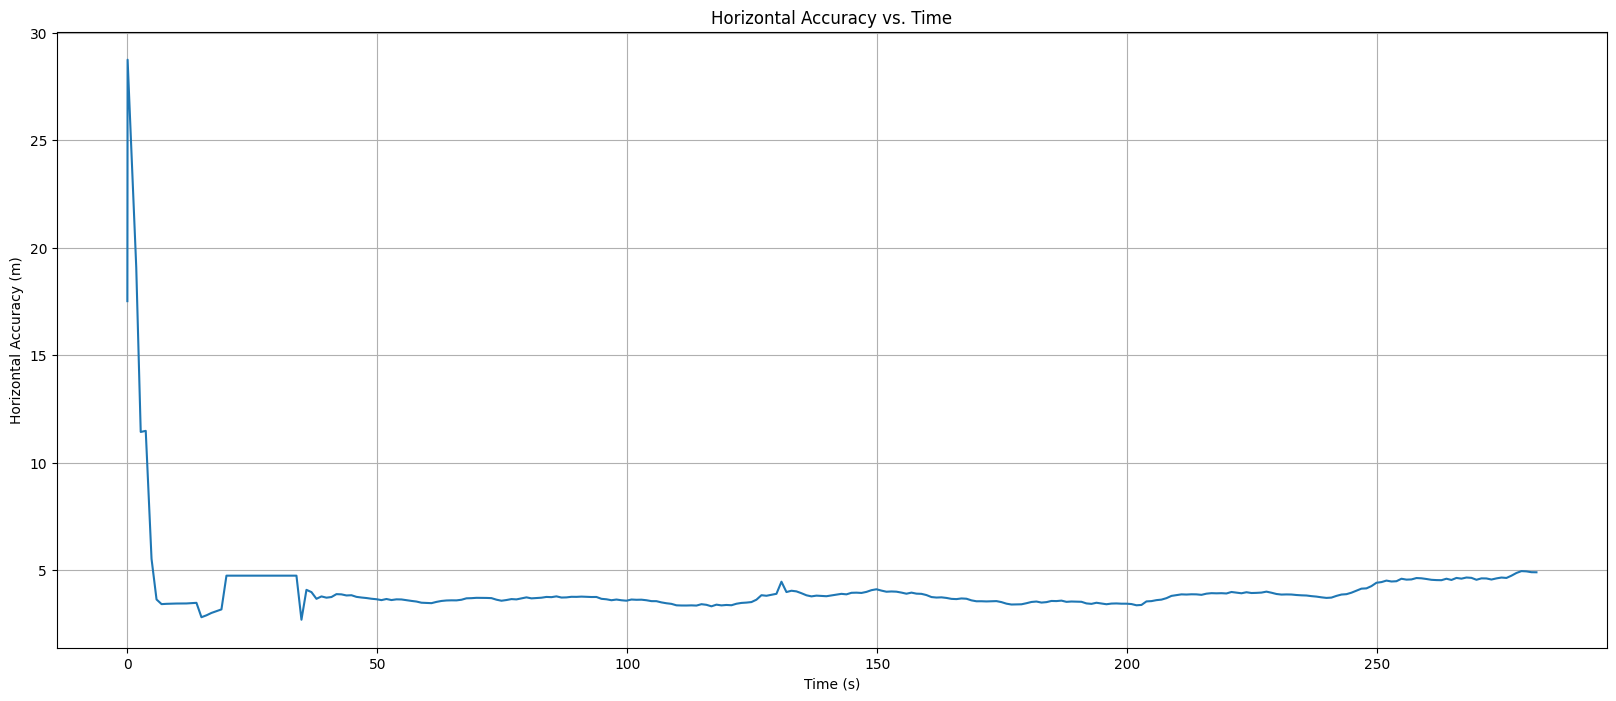

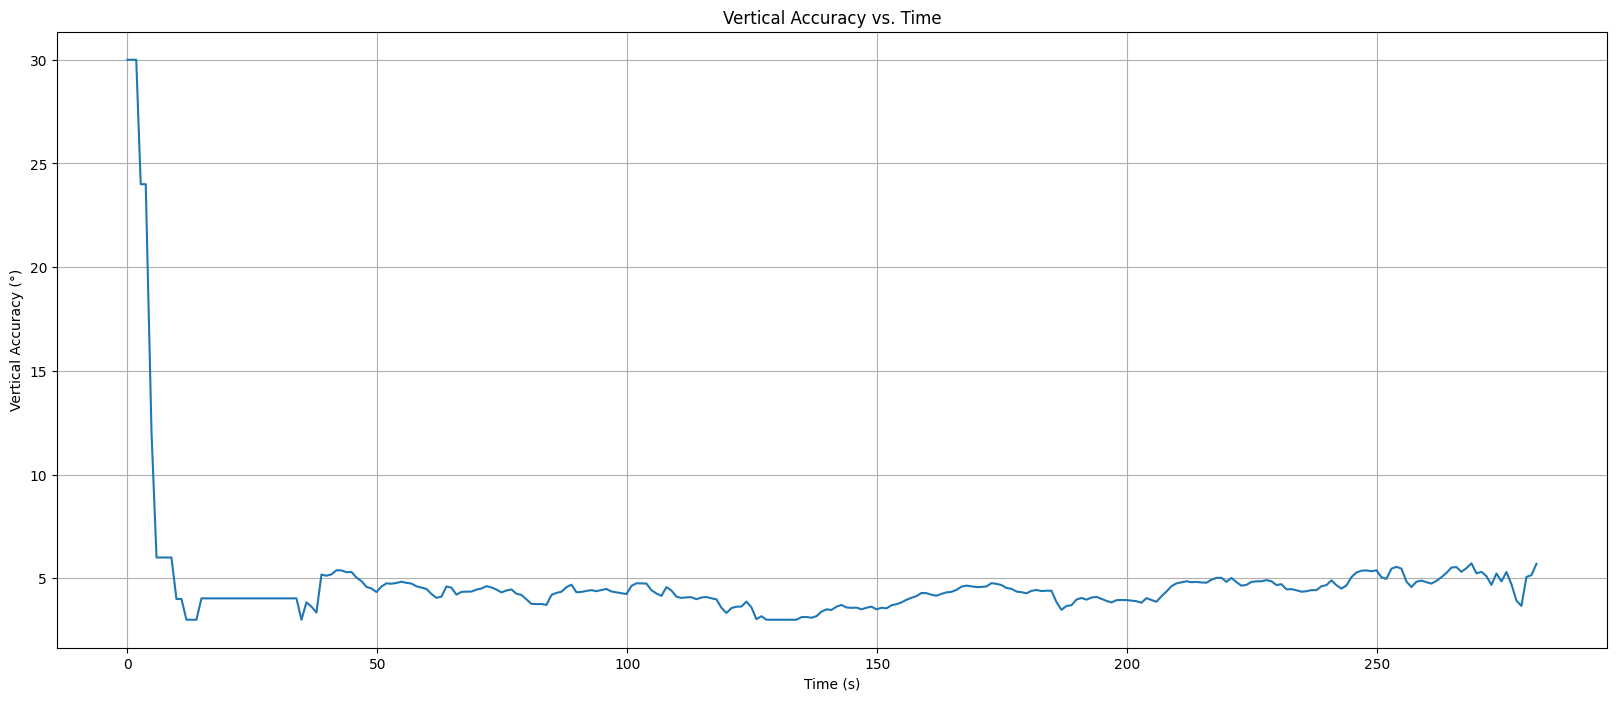

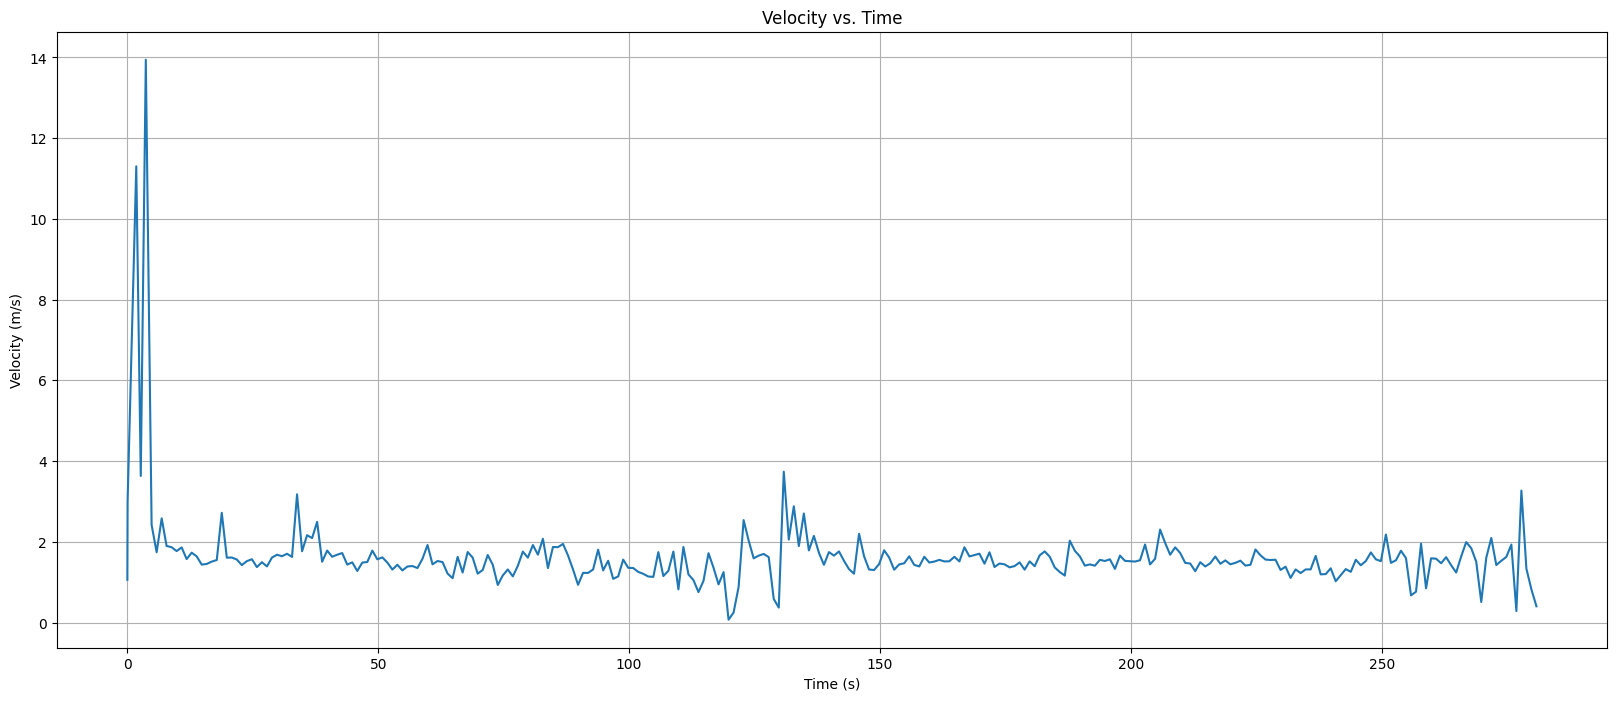

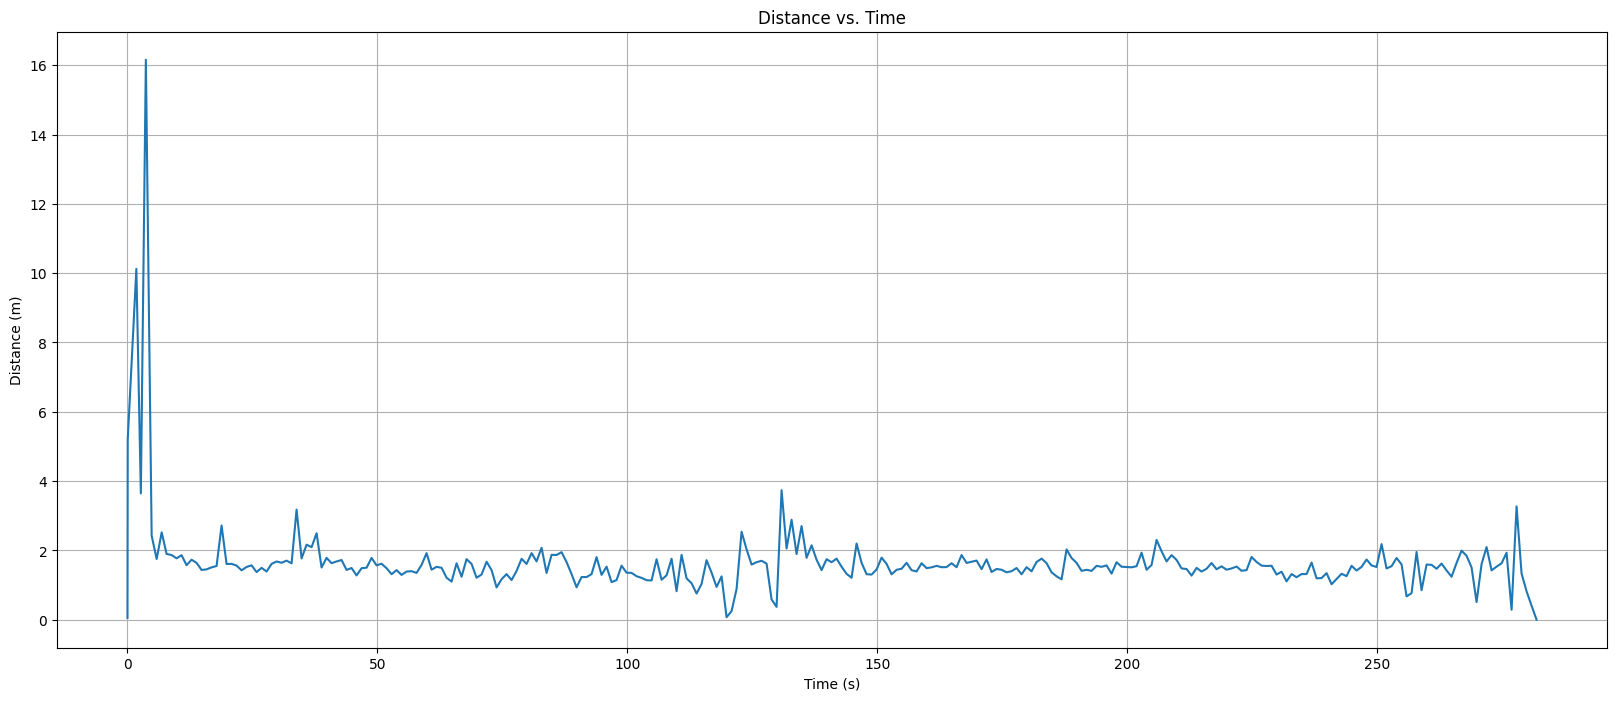

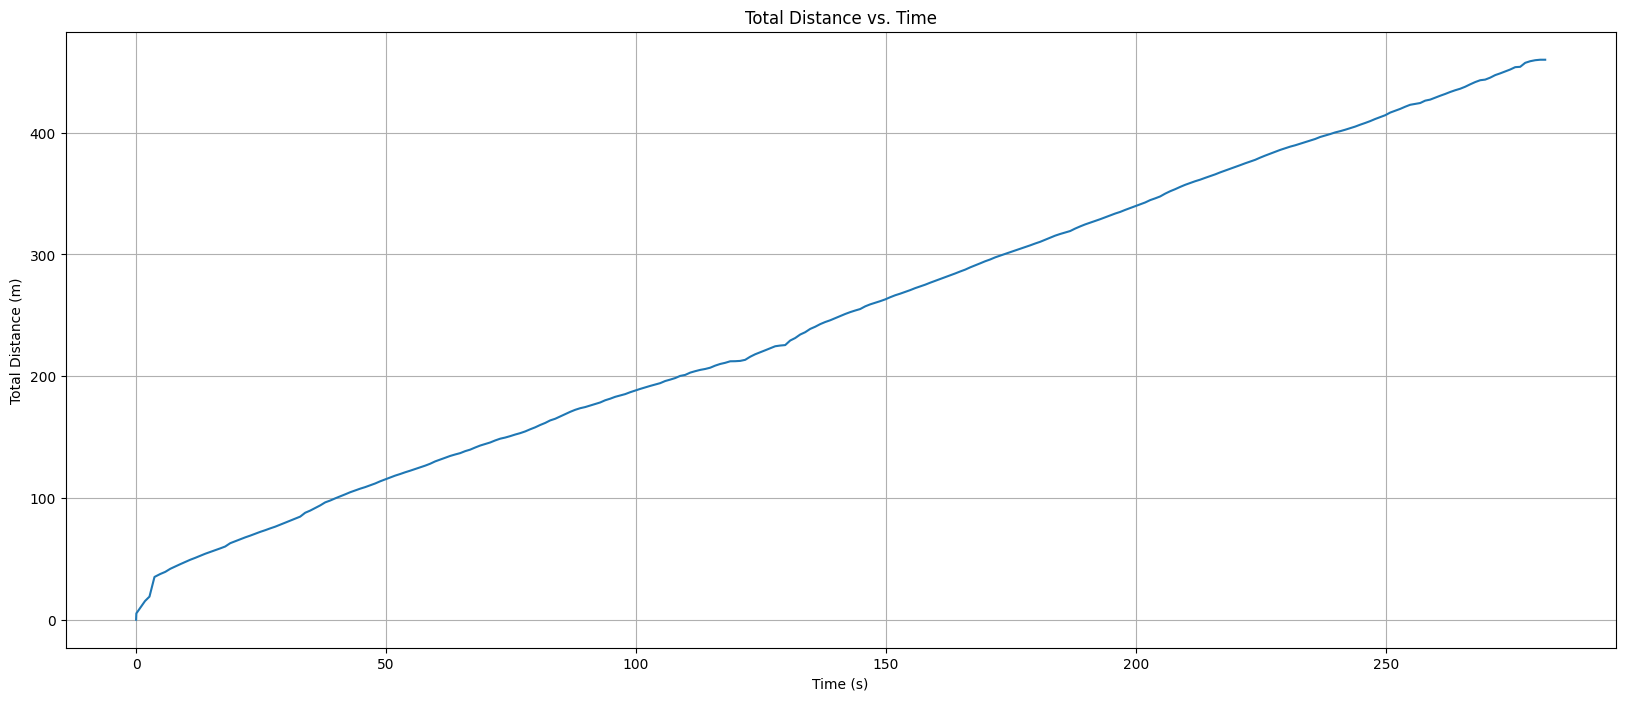

In [260]:
plt.figure(figsize=(20,8))
plt.plot(df_gps['Time (s)'], df_gps['Horizontal Accuracy (m)'])
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Accuracy (m)')
plt.grid()
plt.title('Horizontal Accuracy vs. Time')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_gps['Time (s)'], df_gps['Vertical Accuracy (°)'])
plt.xlabel('Time (s)')
plt.ylabel('Vertical Accuracy (°)')
plt.grid()
plt.title('Vertical Accuracy vs. Time')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_gps['Time (s)'], df_gps['velocity'])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid()
plt.title('Velocity vs. Time')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_gps['Time (s)'], df_gps['dist'])
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.grid()
plt.title('Distance vs. Time')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_gps['Time (s)'], df_gps['tot_dist'])
plt.xlabel('Time (s)')
plt.ylabel('Total Distance (m)')
plt.grid()
plt.title('Total Distance vs. Time')
plt.show()

In [261]:
# luodaan karttapohja, jossa on määritelty keskipisteen koordinaatit ja zoomauksen taso alussa

start_lat = df_gps['Latitude (°)'].mean()
start_lon = df_gps['Longitude (°)'].mean()
my_map = folium.Map(location = [start_lat, start_lon], zoom_start = 17)

# piirretään havainnot kartalle

folium.PolyLine(df_gps[['Latitude (°)', 'Longitude (°)']], color="blue", weight=2.5, opacity=1).add_to(my_map)

my_map.save('map.html')
my_map

In [262]:
# askelpituus (lasketun askelmäärän ja matkan perusteella)

steps_avg = (steps_lowpass + steps_fourier) / 2
step_length = df_gps['tot_dist'].max() / steps_avg
print("Askelten pituus (m):", step_length)

Askelten pituus (m): 0.8400331764001095


In [263]:
# PALAUTETTAVA LOPPUDATA

print("Askelten määrä, Butterworth-alipäästösuodatettu:", steps_lowpass)
print("Askelten määrä, Fourier-muunnoksella laskettuna:", steps_fourier)
print("Askelten määrä, keskiarvo:", steps_avg)
print("Kokonaismatka:", round(total_distance, 2), "m")
print("Askeleen pituus:", round(step_length, 3), "m")
print("Keskinopeus:", round(velocity_avg, 2), "m/s")

Askelten määrä, Butterworth-alipäästösuodatettu: 545.0
Askelten määrä, Fourier-muunnoksella laskettuna: 550.0
Askelten määrä, keskiarvo: 547.5
Kokonaismatka: 459.92 m
Askeleen pituus: 0.84 m
Keskinopeus: 1.63 m/s
